In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("📦 All libraries imported successfully.")


📦 All libraries imported successfully.


In [5]:
data_path = "F:\Sepsis_Early_Prediction_12hr\data\processed\cleaned_12hr_data.csv"
data = pd.read_csv(data_path)

print("✅ Data loaded successfully!")
print("Shape:", data.shape)
data.head()


✅ Data loaded successfully!
Shape: (1552210, 66)


,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,SBP_diff,MAP_mean_6h,MAP_std_6h,MAP_diff,DBP_mean_6h,DBP_std_6h,DBP_diff,Resp_mean_6h,Resp_std_6h,Resp_diff
0,0,0,83.5,98.0,37.0,121.0,80.00,62.0,18.0,33.0,...,NaN,80.000000,NaN,NaN,62.0,NaN,NaN,18.000000,NaN,NaN
1,1,1,97.0,95.0,37.0,98.0,75.33,62.0,19.0,33.0,...,-23.0,77.665000,3.302189,-4.67,62.0,0.0,0.0,18.500000,0.707107,1.0
2,2,2,89.0,99.0,37.0,122.0,86.00,62.0,22.0,33.0,...,24.0,80.443333,5.348797,10.67,62.0,0.0,0.0,19.666667,2.081666,3.0
3,3,3,90.0,95.0,37.0,121.0,80.00,62.0,30.0,33.0,...,-1.0,80.332500,4.372897,-6.00,62.0,0.0,0.0,22.250000,5.439056,8.0
4,4,4,103.0,88.5,37.0,122.0,91.33,62.0,24.5,33.0,...,1.0,82.532000,6.207308,11.33,62.0,0.0,0.0,22.700000,4.816638,-5.5


In [6]:
target = "SepsisLabel_12hr"
drop_cols = ["SepsisLabel", "Patient_ID", target]

X = data.drop(columns=drop_cols)
y = data[target]

print("📊 Feature matrix shape:", X.shape)
print("🎯 Target distribution:\n", y.value_counts())


📊 Feature matrix shape: (1552210, 63)
🎯 Target distribution:
 SepsisLabel_12hr
0.0    1531577
1.0      20633
Name: count, dtype: int64


In [7]:
patients = data["Patient_ID"].unique()

train_patients, test_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=42,
    stratify=data.groupby("Patient_ID")[target].max()
)

train_df = data[data["Patient_ID"].isin(train_patients)]
test_df = data[data["Patient_ID"].isin(test_patients)]

X_train = train_df.drop(columns=drop_cols)
y_train = train_df[target]

X_test  = test_df.drop(columns=drop_cols)
y_test  = test_df[target]

print("📚 Training samples:", X_train.shape)
print("🧪 Testing samples:", X_test.shape)
print("Target (train):\n", y_train.value_counts())


📚 Training samples: (1241753, 63)
🧪 Testing samples: (310457, 63)
Target (train):
 SepsisLabel_12hr
0.0    1225266
1.0      16487
Name: count, dtype: int64


In [8]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled  = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols].fillna(0))
X_test_scaled[numeric_cols]  = scaler.transform(X_test[numeric_cols].fillna(0))

print("⚖️ Numeric scaling complete.")
print("Scaled feature sample:\n")
X_train_scaled[numeric_cols].head()


⚖️ Numeric scaling complete.
Scaled feature sample:



,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,SBP_diff,MAP_mean_6h,MAP_std_6h,MAP_diff,DBP_mean_6h,DBP_std_6h,DBP_diff,Resp_mean_6h,Resp_std_6h,Resp_diff
0,-0.890083,-0.890083,-0.059137,0.257526,0.017543,-0.104804,-0.136696,-0.111479,-0.125651,0.003871,...,-0.003702,-0.164029,-1.378034,-0.003550,-0.131611,-1.01199,-0.004806,-0.139516,-1.357425,-0.008010
1,-0.855031,-0.855031,0.761068,-0.831035,0.017543,-1.175715,-0.441853,-0.111479,0.087685,0.003871,...,-1.445491,-0.349659,-0.778157,-0.384762,-0.131611,-1.01199,-0.004806,-0.004572,-0.972352,0.236653
2,-0.819979,-0.819979,0.275020,0.620380,0.017543,-0.058242,0.255368,-0.111479,0.727690,0.003871,...,1.500774,-0.128785,-0.406370,0.867443,-0.131611,-1.01199,-0.004806,0.310298,-0.223799,0.725980
3,-0.784928,-0.784928,0.335776,-0.831035,0.017543,-0.104804,-0.136696,-0.111479,2.434372,0.003871,...,-0.066388,-0.137596,-0.583652,-0.493330,-0.131611,-1.01199,-0.004806,1.007511,1.604556,1.949296
4,-0.749876,-0.749876,1.125603,-3.189584,0.017543,-0.058242,0.603652,-0.111479,1.261028,0.003871,...,0.058985,0.037262,-0.250412,0.921318,-0.131611,-1.01199,-0.004806,1.128961,1.265602,-1.353658


In [9]:
print("🔄 Applying SMOTE to balance the dataset...")

X_train_scaled_num = X_train_scaled[numeric_cols]

smote = SMOTE(
    random_state=42,
    sampling_strategy=0.3,
    k_neighbors=3
)

X_train_res_scaled, y_train_res = smote.fit_resample(X_train_scaled_num, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", y_train_res.value_counts().to_dict())
print("Resampled shape:", X_train_res_scaled.shape)


🔄 Applying SMOTE to balance the dataset...
Before SMOTE: {0.0: 1225266, 1.0: 16487}
After SMOTE: {0.0: 1225266, 1.0: 367579}
Resampled shape: (1592845, 63)


In [10]:
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=25,
    min_samples_split=8,
    min_samples_leaf=3,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

print("🚀 Training Random Forest...")
rf_model.fit(X_train_res_scaled, y_train_res)
print("🎉 Training complete!")


🚀 Training Random Forest...
🎉 Training complete!


In [11]:
rf_probs = rf_model.predict_proba(X_test_scaled[numeric_cols])[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, rf_preds)
f1 = f1_score(y_test, rf_preds)
auc = roc_auc_score(y_test, rf_probs)

cm = confusion_matrix(y_test, rf_preds)

print("📈 Model Evaluation Results")
print("----------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, rf_preds))


📈 Model Evaluation Results
----------------------------
Accuracy : 0.9638
F1-Score : 0.1291
AUC      : 0.7503

Confusion Matrix:
[[298371   7940]
 [  3312    834]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    306311
         1.0       0.10      0.20      0.13      4146

    accuracy                           0.96    310457
   macro avg       0.54      0.59      0.56    310457
weighted avg       0.98      0.96      0.97    310457



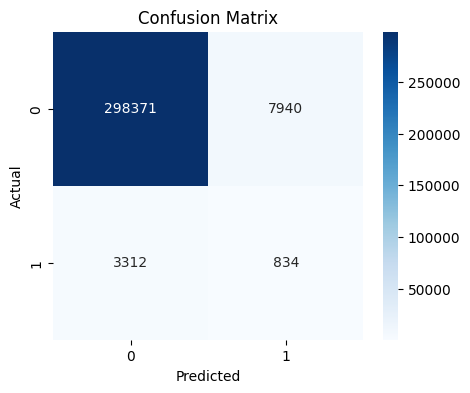

In [12]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


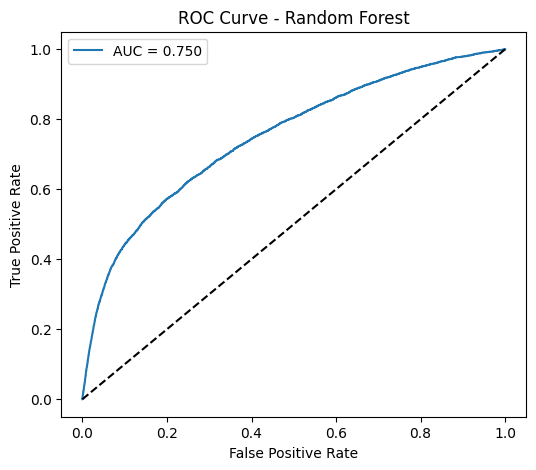

In [13]:
fpr, tpr, _ = roc_curve(y_test, rf_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


In [15]:
pipeline = Pipeline([
    ("scaler", scaler),
    ("rf", rf_model)
])

joblib.dump(pipeline, "../models/rf_pipeline_with_scaler.pkl")
print("✅ Pipeline saved as ../models/rf_pipeline_with_scaler.pkl")

# Optional backups
joblib.dump(rf_model, "../models/random_forest_model.pkl")
joblib.dump(scaler, "../models/scaler.pkl")
print("📁 Raw model & scaler saved as backup in ../models/")


✅ Pipeline saved as ../models/rf_pipeline_with_scaler.pkl
📁 Raw model & scaler saved as backup in ../models/
